In [1]:
import os
os.environ["CUDA_DIVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from IPython.display import Image
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

fname = 'sample2.wav'
fft_size = 1024
fft_hop = 256

/home/201850854/.conda/envs/py3.5_tf1.12/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/201850854/.conda/envs/py3.5_tf1.12/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/201850854/.conda/envs/py3.5_tf1.12/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/201850854/.conda/envs/

In [2]:
def diff(x, axis=1):
    shape = x.get_shape()
    if axis >= len(shape):
        raise ValueError('Invalid axis index: %d for tensor with only %d axes.'
                        % (axis, len(shape)))
    begin_back = [0 for unused_s in range(len(shape))]
    begin_front = [0 for unused_s in range(len(shape))]
    begin_front[axis] = 1
    
    size = shape.as_list()
    size[axis] -= 1
    slice_front = tf.slice(x, begin_front, size)
    slice_back = tf.slice(x, begin_back, size)
    d = slice_front - slice_back
    return d

def unwrap(phase_angle, discont=np.pi, axis=-1):
    
    
    dd = diff(phase_angle, axis=axis)
    ddmod = tf.mod(dd + np.pi, 2.0 * np.pi) - np.pi
    idx = tf.logical_and(tf.equal(ddmod, -np.pi), tf.greater(dd, 0))
    ddmod = tf.where(idx, tf.ones_like(ddmod) * np.pi, ddmod)
    ph_correct = ddmod - dd
    idx = tf.less(tf.abs(dd), discont)
    ddmod = tf.where(idx, tf.zeros_like(ddmod), dd)
    ph_cumsum = tf.cumsum(ph_correct, axis=axis)
    
    shape = phase_angle.get_shape().as_list()
    shape[axis] = 1
    ph_cumsum = tf.concat([tf.zeros(shape, dtype=phase_angle.dtype), ph_cumsum], axis=axis)
    unwrapped = phase_angle + ph_cumsum
    return unwrapped

def instantaneous_frequency(phase_angle, time_axis=-2):
    
    
    phase_unwrapped = unwrap(phase_angle, axis=time_axis)
    dphase = diff(phase_unwrapped, axis=time_axis)
    
    # Add an initial phase to dphase
    size = phase_unwrapped.get_shape().as_list()
    size[time_axis] = 1
    begin = [0 for unused_s in size]
    phase_slice = tf.slice(phase_unwrapped, begin, size)
    dphase = tf.concat([phase_slice, dphase], axis=time_axis) / np.pi
    return dphase

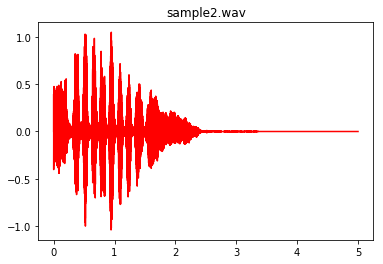

In [3]:
audio_data, sample_rate = librosa.load(
    path='./' + fname,
    sr=16000,
    mono=True,
    duration=None
)
time = np.linspace(0, len(audio_data)/sample_rate, len(audio_data))
plt.plot(time, audio_data, color='r', label='waveform')
plt.title(fname)
plt.show()

D ndarray shape: 		(513, 313)
magnitude ndarray shape: 	(513, 313)
phase ndarray shape: 		(513, 313)


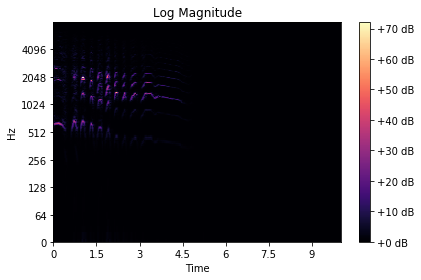

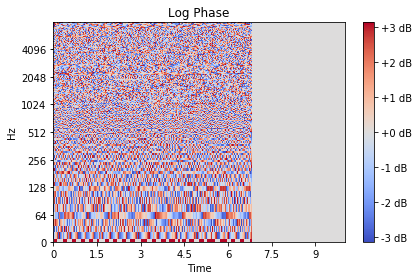

In [4]:
D = librosa.stft(
    y=audio_data,
    n_fft=fft_size,
    hop_length=fft_hop,
    win_length=fft_size,
    window='hann',
    center=True
)
mag = np.abs(D)
phase = np.angle(D)

print("D ndarray shape: \t\t" + str(D.shape))
print("magnitude ndarray shape: \t" + str(mag.shape))
print("phase ndarray shape: \t\t" + str(phase.shape))

librosa.display.specshow(
    mag,
    x_axis='time',
    y_axis='log',
    sr=sample_rate,
    fmax=sample_rate//2
)
plt.title("Log Magnitude")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

librosa.display.specshow(
    phase,
    x_axis='time',
    y_axis='log',
    sr=sample_rate,
    fmax=sample_rate//2
)
plt.title("Log Phase")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

mag_dB ndarray shape: 		(513, 313)
mag_dB_sqrt ndarray shape: 	(513, 313)


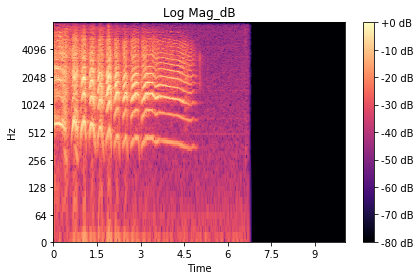

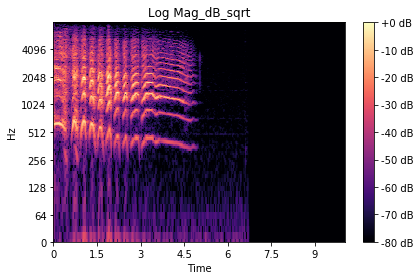

In [5]:
mag_dB = librosa.power_to_db(mag, ref=np.max)
mag_dB_sqrt = librosa.power_to_db(mag**2, ref=np.max)

print("mag_dB ndarray shape: \t\t" + str(mag_dB.shape))
print("mag_dB_sqrt ndarray shape: \t" + str(mag_dB_sqrt.shape))

librosa.display.specshow(
    mag_dB,
    x_axis='time',
    y_axis='log',
    sr=sample_rate,
    fmax=sample_rate//2
)
plt.title("Log Mag_dB")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

librosa.display.specshow(
    mag_dB_sqrt,
    x_axis='time',
    y_axis='log',
    sr=sample_rate,
    fmax=sample_rate//2
)
plt.title("Log Mag_dB_sqrt")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

phase_dB ndarray shape: 	(513, 313)
phase_dB_sqrt ndarray shape: 	(513, 313)


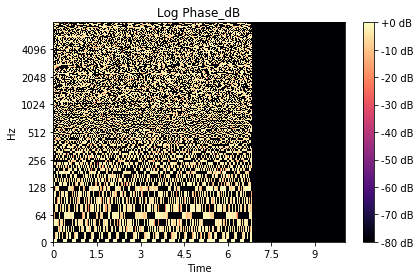

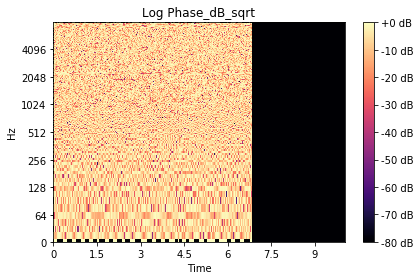

In [6]:
phase_dB = librosa.power_to_db(phase, ref=np.max)
phase_dB_sqrt = librosa.power_to_db(phase**2, ref=np.max)

print("phase_dB ndarray shape: \t" + str(phase_dB.shape))
print("phase_dB_sqrt ndarray shape: \t" + str(phase_dB_sqrt.shape))

librosa.display.specshow(
    phase_dB,
    x_axis='time',
    y_axis='log',
    sr=sample_rate,
    fmax=sample_rate//2
)
plt.title("Log Phase_dB")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

librosa.display.specshow(
    phase_dB_sqrt,
    x_axis='time',
    y_axis='log',
    sr=sample_rate,
    fmax=sample_rate//2
)
plt.title("Log Phase_dB_sqrt")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

mel_mag_dB_sqrt ndarray shape: 		(128, 313)
mel_phase_dB_sqrt ndarray shape: 	(128, 313)


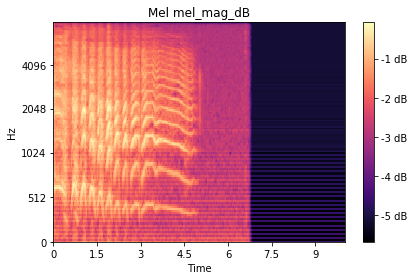

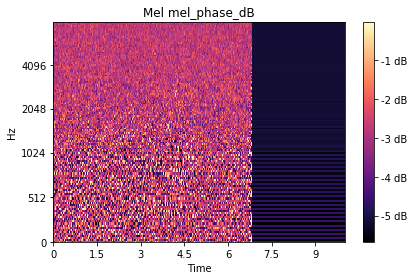

In [7]:
mel_mag_dB = librosa.feature.melspectrogram(
    S=mag_dB,
    sr=sample_rate,
    n_mels=128,
    fmax=sample_rate//2
)
mel_phase_dB = librosa.feature.melspectrogram(
    S=phase_dB,
    sr=sample_rate,
    n_mels=128,
    fmax=sample_rate//2
)

print("mel_mag_dB_sqrt ndarray shape: \t\t" + str(mel_mag_dB.shape))
print("mel_phase_dB_sqrt ndarray shape: \t" + str(mel_phase_dB.shape))

librosa.display.specshow(
    mel_mag_dB,
    x_axis='time',
    y_axis='mel',
    sr=sample_rate,
    fmax=sample_rate//2
)
plt.title("Mel mel_mag_dB")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

librosa.display.specshow(
    mel_phase_dB,
    x_axis='time',
    y_axis='mel',
    sr=sample_rate,
    fmax=sample_rate//2
)
plt.title("Mel mel_phase_dB")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

mel_mag_dB_sqrt ndarray shape: 		(128, 313)
mel_phase_dB_sqrt ndarray shape: 	(128, 313)


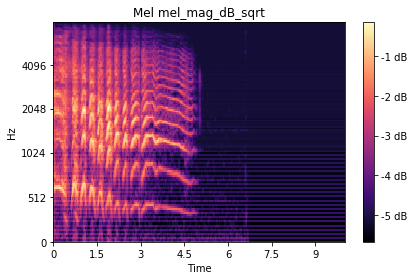

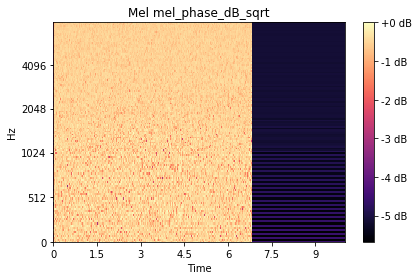

In [8]:
mel_mag_dB_sqrt = librosa.feature.melspectrogram(
    S=mag_dB_sqrt,
    sr=sample_rate,
    n_mels=128,
    fmax=sample_rate//2
)
mel_phase_dB_sqrt = librosa.feature.melspectrogram(
    S=phase_dB_sqrt,
    sr=sample_rate,
    n_mels=128,
    fmax=sample_rate//2
)

print("mel_mag_dB_sqrt ndarray shape: \t\t" + str(mel_mag_dB_sqrt.shape))
print("mel_phase_dB_sqrt ndarray shape: \t" + str(mel_phase_dB_sqrt.shape))

librosa.display.specshow(
    mel_mag_dB_sqrt,
    x_axis='time',
    y_axis='mel',
    sr=sample_rate,
    fmax=sample_rate//2
)
plt.title("Mel mel_mag_dB_sqrt")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

librosa.display.specshow(
    mel_phase_dB_sqrt,
    x_axis='time',
    y_axis='mel',
    sr=sample_rate,
    fmax=sample_rate//2
)
plt.title("Mel mel_phase_dB_sqrt")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


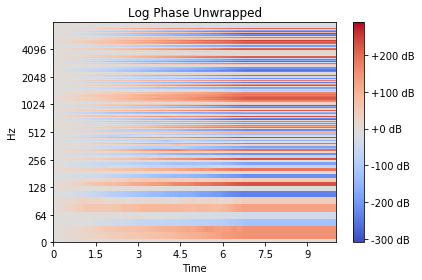

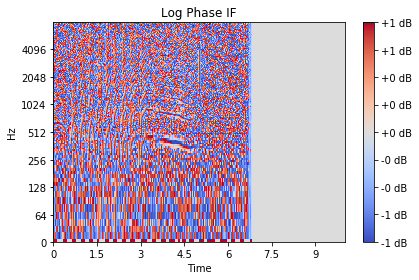

In [9]:
tensor_phase = tf.convert_to_tensor(phase)
tensor_unwrapped = unwrap(tensor_phase, axis=-1)
tensor_instntfreq = instantaneous_frequency(tensor_phase)
unwrapped = (tf.Session().run(tensor_unwrapped))
instantfreq = (tf.Session().run(tensor_instntfreq))

librosa.display.specshow(
    unwrapped,
    x_axis='time',
    y_axis='log',
    sr=sample_rate,
    fmax=sample_rate//2    
)
plt.title("Log Phase Unwrapped")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

librosa.display.specshow(
    instantfreq,
    x_axis='time',
    y_axis='log',
    sr=sample_rate,
    fmax=sample_rate//2    
)
plt.title("Log Phase IF")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

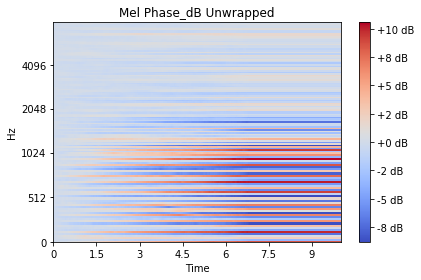

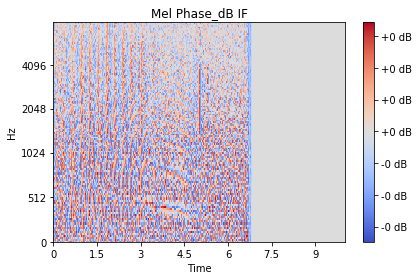

In [10]:
tensor_phase = tf.convert_to_tensor(phase)
tensor_unwrapped = unwrap(tensor_phase, axis=-1)
tensor_instntfreq = instantaneous_frequency(tensor_phase)
unwrapped = (tf.Session().run(tensor_unwrapped))
instantfreq = (tf.Session().run(tensor_instntfreq))

mel_unwrapped = librosa.feature.melspectrogram(
    S=unwrapped,
    sr=sample_rate,
    n_mels=128,
    fmax=sample_rate//2
)

mel_instantfreq = librosa.feature.melspectrogram(
    S=instantfreq,
    sr=sample_rate,
    n_mels=128,
    fmax=sample_rate//2
)

librosa.display.specshow(
    mel_unwrapped,
    x_axis='time',
    y_axis='mel',
    sr=sample_rate,
    fmax=sample_rate//2    
)
plt.title("Mel Phase_dB Unwrapped")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

librosa.display.specshow(
    mel_instantfreq,
    x_axis='time',
    y_axis='mel',
    sr=sample_rate,
    fmax=sample_rate//2    
)
plt.title("Mel Phase_dB IF")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

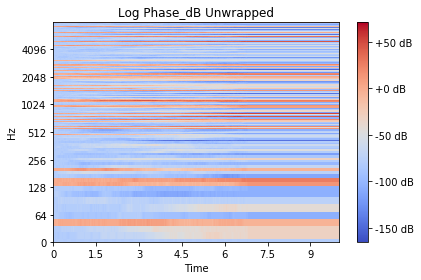

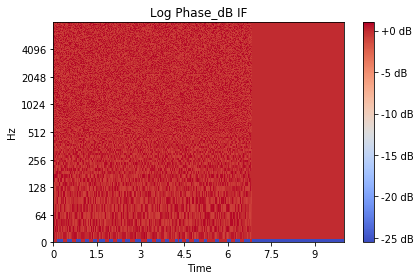

In [11]:
tensor_phase = tf.convert_to_tensor(phase_dB)
tensor_unwrapped = unwrap(tensor_phase, axis=-1)
tensor_instntfreq = instantaneous_frequency(tensor_phase)
unwrapped = (tf.Session().run(tensor_unwrapped))
instantfreq = (tf.Session().run(tensor_instntfreq))

librosa.display.specshow(
    unwrapped,
    x_axis='time',
    y_axis='log',
    sr=sample_rate,
    fmax=sample_rate//2    
)
plt.title("Log Phase_dB Unwrapped")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

librosa.display.specshow(
    instantfreq,
    x_axis='time',
    y_axis='log',
    sr=sample_rate,
    fmax=sample_rate//2    
)
plt.title("Log Phase_dB IF")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

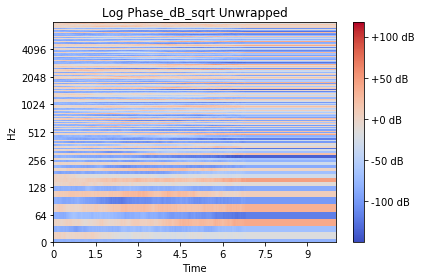

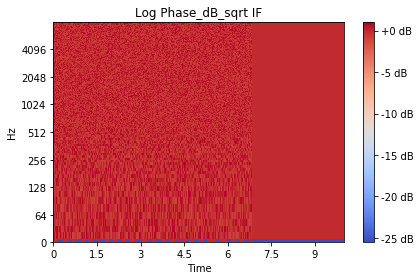

In [12]:
tensor_phase = tf.convert_to_tensor(phase_dB_sqrt)
tensor_unwrapped = unwrap(tensor_phase, axis=-1)
tensor_instntfreq = instantaneous_frequency(tensor_phase)
unwrapped = (tf.Session().run(tensor_unwrapped))
instantfreq = (tf.Session().run(tensor_instntfreq))

librosa.display.specshow(
    unwrapped,
    x_axis='time',
    y_axis='log',
    sr=sample_rate,
    fmax=sample_rate//2    
)
plt.title("Log Phase_dB_sqrt Unwrapped")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

librosa.display.specshow(
    instantfreq,
    x_axis='time',
    y_axis='log',
    sr=sample_rate,
    fmax=sample_rate//2    
)
plt.title("Log Phase_dB_sqrt IF")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

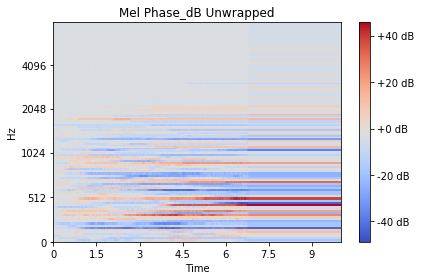

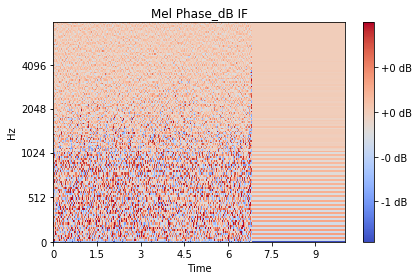

In [13]:
tensor_phase = tf.convert_to_tensor(mel_phase_dB)
tensor_unwrapped = unwrap(tensor_phase, axis=-1)
tensor_instntfreq = instantaneous_frequency(tensor_phase)
unwrapped = (tf.Session().run(tensor_unwrapped))
instantfreq = (tf.Session().run(tensor_instntfreq))

librosa.display.specshow(
    unwrapped,
    x_axis='time',
    y_axis='mel',
    sr=sample_rate,
    fmax=sample_rate//2    
)
plt.title("Mel Phase_dB Unwrapped")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

librosa.display.specshow(
    instantfreq,
    x_axis='time',
    y_axis='mel',
    sr=sample_rate,
    fmax=sample_rate//2    
)
plt.title("Mel Phase_dB IF")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

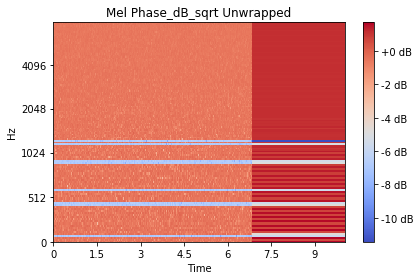

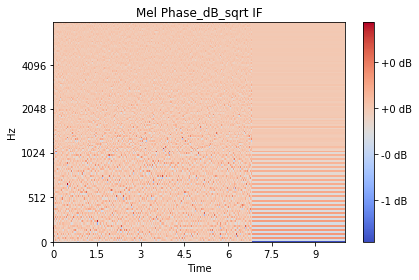

In [14]:
tensor_phase = tf.convert_to_tensor(mel_phase_dB_sqrt)
tensor_unwrapped = unwrap(tensor_phase, axis=-1)
tensor_instntfreq = instantaneous_frequency(tensor_phase)
unwrapped = (tf.Session().run(tensor_unwrapped))
instantfreq = (tf.Session().run(tensor_instntfreq))

librosa.display.specshow(
    unwrapped,
    x_axis='time',
    y_axis='mel',
    sr=sample_rate,
    fmax=sample_rate//2    
)
plt.title("Mel Phase_dB_sqrt Unwrapped")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

librosa.display.specshow(
    instantfreq,
    x_axis='time',
    y_axis='mel',
    sr=sample_rate,
    fmax=sample_rate//2    
)
plt.title("Mel Phase_dB_sqrt IF")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()